In [2]:
from collections import deque, namedtuple
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym

In [3]:
Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "terminated"])

class QNetwork:
    def __init__(self, num_inputs, num_outputs, learning_rate):
        self._model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(num_inputs,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(num_outputs)
        ])
        self._model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss=tf.keras.losses.MeanSquaredError()
        )
        self._loss_fn = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train(self, states, target_q_values):
        with tf.GradientTape() as tape:
            q_values = self._model(states, training=True)
            loss = self._loss_fn(target_q_values, q_values)
        gradients = tape.gradient(loss, self._model.trainable_variables)
        self._model.optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))

    # Predict method, again with manual @tf.function for efficiency.
    @tf.function
    def predict(self, states):
        return self._model(states)


    # The following method copies weights from a given QNetwork to the current one.
    @tf.function
    def copy_weights_from(self, other):
        for var, other_var in zip(self._model.variables, other._model.variables):
            var.assign(other_var)

In [4]:

class DeepQLearningAgent:
    def __init__(
        self,
        num_inputs,
        num_outputs,
        learning_rate=5e-3,
        batch_size=64,
        num_batches=1,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        gamma=0.99,
        target_model_update_interval=100
    ):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.learning_rate = learning_rate

        self.q_network = QNetwork(num_inputs, num_outputs, learning_rate)
        self.target_network = QNetwork(num_inputs, num_outputs, learning_rate)
        self.target_network.copy_weights_from(self.q_network)

        self.replay_buffer = deque(maxlen=100000)

        self.batch_size = batch_size
        self.num_batches = num_batches

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma

        self.target_model_update_interval = target_model_update_interval
        self.update_counter = 0


    # Save the state, action, reward, next_state and terminated to buffer
    def memorize(self, state, action, reward, next_state, terminated):
        self.replay_buffer.append(Transition(np.array(state), action, reward, np.array(next_state), terminated))


    # Returns action - in an epsilon-greedy manner when training, otherwise the best predicted
    def action(self, state, train=False):
        if train and np.random.uniform() < self.epsilon:
            return np.random.randint(self.num_outputs)
        else:
            return np.argmax(self.q_network.predict(np.array(state).reshape(1, -1))[0])


    # Training using the replay buffer
    def train(self):
        # We cannot train when there is not enough data in the replay buffer
        if len(self.replay_buffer) < self.batch_size:
            return

        # Update the target network, when required
        if self.update_counter >= self.target_model_update_interval:
            self.update_counter = 0
            self.target_network.copy_weights_from(self.q_network)

        self.update_counter += 1

        for _ in range(self.num_batches):
            # Sample a minibatch from the buffer
            batch_indices = np.random.choice(len(self.replay_buffer), self.batch_size, replace=False)

            states = np.array([self.replay_buffer[i].state for i in batch_indices])
            next_states = np.array([self.replay_buffer[i].next_state for i in batch_indices])
            actions = np.array([self.replay_buffer[i].action for i in batch_indices])
            rewards = np.array([self.replay_buffer[i].reward for i in batch_indices])
            not_terminations = np.array([not self.replay_buffer[i].terminated for i in batch_indices])

            states = states.reshape((-1, self.num_inputs))
            next_states = next_states.reshape((-1, self.num_inputs))

            # Predict the Q-values
            predicted = np.array(self.q_network.predict(states))
            next_predicted = np.array(self.target_network.predict(next_states))

            # Compute the target values (using the Bellman equations and target network)
            # (When truncated, we did not reach a final state and the episode would continue to go on -
            # if not for the timestep limit meant only as a way of keeping the episodes reasonably long,
            # so we do treat the state the episode was truncated in as any other state, unlike the state
            # the episode was terminated in, when we do not add the estimate of the future return to the
            # current reward when computing the target Q-value.)
            target_q_values = predicted
            target_q_values[range(target_q_values.shape[0]), actions] = \
                rewards + not_terminations * self.gamma * np.max(next_predicted, axis=-1)

            self.q_network.train(states, target_q_values)

        # Lower the epsilon for the epsilon-greedy strategy
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * self.epsilon_decay

In [5]:
def preprocess_state(_state):
    return np.array([_state[0] / 32.0,_state[1] / 11.0,float(_state[2])], dtype=np.float32)

Train the model for Blackjack

In [6]:
env = gym.make('Blackjack-v1', natural=True, sab=False)
num_inputs = 3
num_outputs = env.action_space.n

agent = DeepQLearningAgent(3,2)

num_episodes = 10000
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = preprocess_state(state)
    total_reward = 0
    terminated = False

    while not terminated:
        action = agent.action(state, train=True)
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = preprocess_state(next_state)

        agent.memorize(state, action, reward, next_state, terminated or truncated)
        agent.train()

        state = next_state
        total_reward += reward

    reward_history.append(total_reward)

    if episode % 500 == 0:
        avg_reward = np.mean(reward_history[-500:])
        print(f"Episode {episode}, Avg reward (last 500): {avg_reward:.3f}, Epsilon: {agent.epsilon:.3f}")


Episode 0, Avg reward (last 500): -1.000, Epsilon: 1.000
Episode 500, Avg reward (last 500): -0.184, Epsilon: 0.043
Episode 1000, Avg reward (last 500): -0.050, Epsilon: 0.010
Episode 1500, Avg reward (last 500): -0.098, Epsilon: 0.010
Episode 2000, Avg reward (last 500): -0.047, Epsilon: 0.010
Episode 2500, Avg reward (last 500): 0.017, Epsilon: 0.010
Episode 3000, Avg reward (last 500): -0.050, Epsilon: 0.010
Episode 3500, Avg reward (last 500): -0.175, Epsilon: 0.010
Episode 4000, Avg reward (last 500): 0.026, Epsilon: 0.010
Episode 4500, Avg reward (last 500): -0.095, Epsilon: 0.010
Episode 5000, Avg reward (last 500): -0.070, Epsilon: 0.010
Episode 5500, Avg reward (last 500): -0.034, Epsilon: 0.010
Episode 6000, Avg reward (last 500): -0.055, Epsilon: 0.010
Episode 6500, Avg reward (last 500): -0.059, Epsilon: 0.010
Episode 7000, Avg reward (last 500): -0.003, Epsilon: 0.010
Episode 7500, Avg reward (last 500): 0.047, Epsilon: 0.010
Episode 8000, Avg reward (last 500): 0.013, Eps

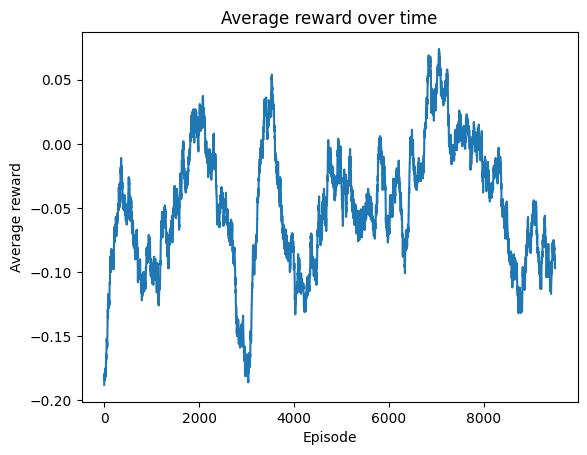

In [7]:
plt.plot(np.convolve(reward_history, np.ones(500)/500, mode='valid'))
plt.title("Average reward over time")
plt.xlabel("Episode")
plt.ylabel("Average reward")
plt.show()


Test the BlackJack bot. The bot was quite fast at learning and manages to get optimal results. As on average it wins around 42% of games ties 8% of the games and loses around 50%. Due to how the rules in blackjack work this is considered to be optimal. Getting better results we would need to start using the same deck and card counting.

In [10]:
agent.epsilon = 0.0
wins = 0
ties = 0
losses = 0
episodes = 10000

for i in range(episodes):
    state, _ = env.reset()
    state = preprocess_state(state)
    done = False
    while not done:
        action = agent.action(state, train=False)
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = preprocess_state(next_state)
        done = terminated or truncated
    if reward > 0:
        wins += 1
    elif reward == 0:
        ties += 1
    else:
        losses += 1
print(f"Win rate: {wins / episodes}")
print(f"Tie rate: {ties / episodes}")
print(f"Loss rate: {losses / episodes}")

Win rate: 0.4208
Tie rate: 0.0951
Loss rate: 0.4841
